Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


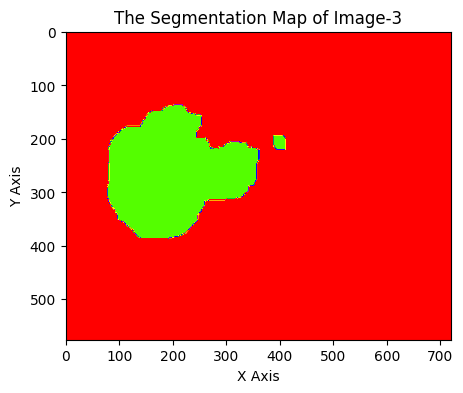

The overall accuracy is: 0.8968605324074074
The precision value is: 0.43004543331493356
The recall value is: 0.43004543331493356
The fscore value is: 0.43004543331493356
The specificity value is: 0.9290794006382485
The dice index value is: 0.4864202867228586
-------------------------------------------


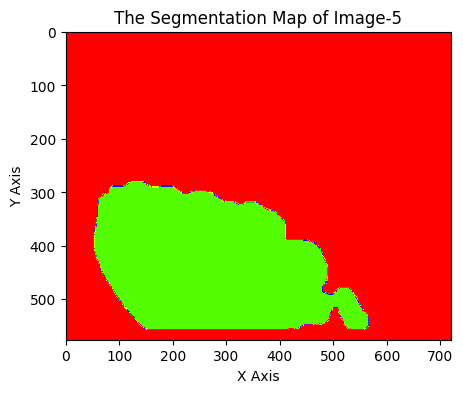

The overall accuracy is: 0.7535469714506173
The precision value is: 0.2452363226624278
The recall value is: 0.2452363226624278
The fscore value is: 0.2452363226624278
The specificity value is: 0.7934171721872358
The dice index value is: 0.32294433661674204
-------------------------------------------


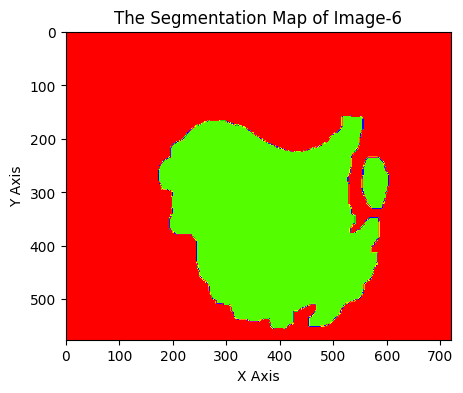

The overall accuracy is: 0.817457561728395
The precision value is: 0.4374109854659643
The recall value is: 0.4374109854659643
The fscore value is: 0.4374109854659643
The specificity value is: 0.8145619701023172
The dice index value is: 0.5739018844136254
-------------------------------------------


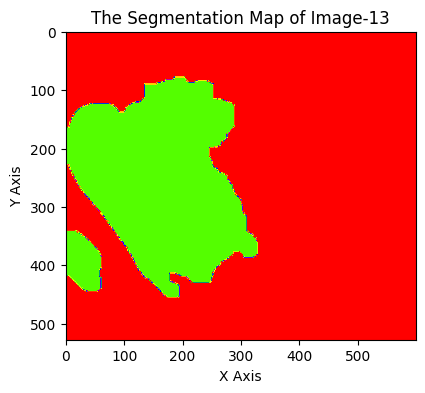

The overall accuracy is: 0.8077588383838383
The precision value is: 0.7186731887761311
The recall value is: 0.7186731887761311
The fscore value is: 0.7186731887761312
The specificity value is: 0.8948880685227955
The dice index value is: 0.6598147755074681
-------------------------------------------


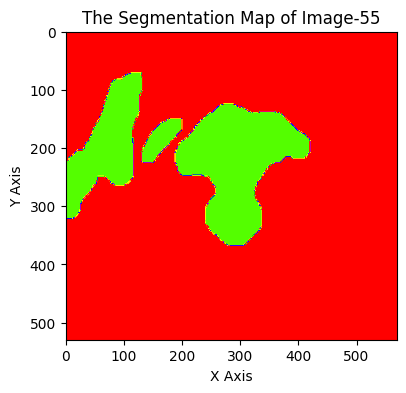

The overall accuracy is: 0.8602350215160542
The precision value is: 0.1872943661399732
The recall value is: 0.1872943661399732
The fscore value is: 0.1872943661399732
The specificity value is: 0.8623323276143819
The dice index value is: 0.30402030758072757
-------------------------------------------


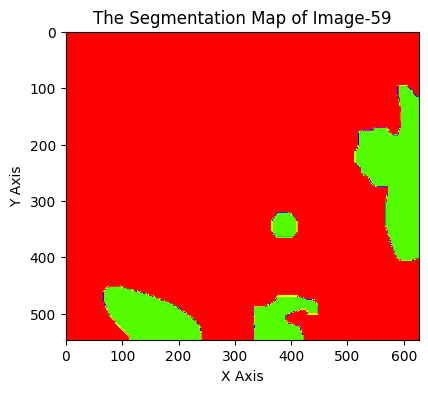

The overall accuracy is: 0.766182949479399
The precision value is: 0.2159741482405028
The recall value is: 0.2159741482405028
The fscore value is: 0.2159741482405028
The specificity value is: 0.8919228907548877
The dice index value is: 0.17470772270706406
-------------------------------------------


KeyboardInterrupt: ignored

In [1]:
import cv2 as cv
from PIL import Image
import os
import cv2 as cv
import numpy as np
from scipy.ndimage import binary_fill_holes
import copy
from PIL.ImageEnhance import Contrast
import cv2
from PIL import ImageOps
from google.colab import drive
from PIL import Image
from skimage.feature import peak_local_max
from PIL import Image
from cv2 import THRESH_BINARY 
from PIL import Image
from skimage.morphology import binary_opening
from skimage import io
from scipy.spatial.distance import cdist
from scipy.ndimage import distance_transform_edt
from numpy import pad
from PIL import ImageEnhance
from matplotlib import pyplot as plt
from queue import Queue
import skimage.filters as filters
from cv2 import THRESH_OTSU

########Contributors#####################
########Barış Kaplan(0069054)############
########Canberk Eker(0060233)############

def find_classification_boundary(img_blr, row_rng, column_rng):
     for index_row in row_rng:
        for index_column in column_rng:
            if img_blr[index_row][index_column] <= 155:
                img_blr[index_row][index_column] = 0
            elif img_blr[index_row][index_column] > 155:
                img_blr[index_row][index_column] = 1
       


def apply_thresholding(img):
    otsu = cv2.THRESH_OTSU 
    binary = cv2.THRESH_BINARY
    # application of the thresholding method of otsu #
    threshold, estimated_foreground_mask = cv2.threshold(img, 0, 255, otsu + binary)
    estimated_foreground_mask = np.array(estimated_foreground_mask) # conversion to numpy array #
    return estimated_foreground_mask


def preprocess_image(image) -> np.ndarray:
    image = cv2.fastNlMeansDenoising(image,None,3,7,21)
    pil_image = Image.fromarray(image) # conversion from grayscale to a PIL image.
    contrast_object = ImageEnhance.Contrast(pil_image)
    enhanced_pil_image = contrast_object.enhance(1.65) # Enhancing the contrast of the image #
    gaussian_blurred = cv2.GaussianBlur(np.array(enhanced_pil_image), (5,5), 0) # Applying a gaussian blur to the enhanced image #
    return gaussian_blurred

def morphological_ops(estimated_msk):
  estimated_msk = cv2.morphologyEx(estimated_msk, cv2.MORPH_CLOSE, cv2.getStructuringElement(cv2.MORPH_RECT, (13, 13)))
  estimated_msk = cv2.dilate(estimated_msk, cv2.getStructuringElement(cv2.MORPH_RECT, (5, 5)), iterations = 2)
  estimated_msk = binary_fill_holes(estimated_msk)
  estimated_msk = cv2.erode(estimated_msk.astype(np.uint8), cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3)), iterations = 2)
  estimated_msk = cv2.morphologyEx(estimated_msk, cv2.MORPH_CLOSE, cv2.getStructuringElement(cv2.MORPH_RECT, (7, 7)))
  estimated_msk = cv2.morphologyEx(estimated_msk, cv2.MORPH_OPEN, cv2.getStructuringElement(cv2.MORPH_RECT, (9, 9)), iterations = 2)
  return estimated_msk

# function to calculate the true positive, false positive and false negative counter values by comparing estimated and gold masks ##
def calculate_tp_tn_fp_fn_counters(estimated_mask, gold_mask_data):
    true_pos = 0
    false_pos = 0

    true_neg = 0
    false_neg = 0

    rows_range = range(0, estimated_mask.shape[0])
    column_range = range(0, estimated_mask.shape[1])

    for index_row in rows_range:  
        for index_column in column_range:  
            estimated_val = estimated_mask[index_row][index_column]
            gold_val = gold_mask_data[index_row][index_column]

            if estimated_val == 1 and gold_val == 1:  
                true_pos += 1
            elif estimated_val == 1 and gold_val == 0:  
                false_pos += 1
            elif estimated_val == 0 and gold_val == 1:  
                false_neg += 1
            elif estimated_val == 0 and gold_val == 0:  
                true_neg += 1

    return (true_pos, true_neg, false_pos, false_neg)  



drive.mount('/content/drive')
import os

def evaluate_f_score(precision, recall):
  if precision + recall == 0:
    return 0
  return (2 * precision * recall) / (precision + recall)


def evaluate_precision(tp, fp):
  if tp + fp == 0:
    return 0
  return tp / (tp + fp)

def evaluate_recall(tp,fn):
  if tp + fn == 0:
    return 0
  return tp / (tp + fn)

def calculate_dice_index(tp, fp, fn):
  if 2 * tp + fp + fn == 0:
    return 0
  return (2 * tp) / (2 * tp + fp + fn)

def calculate_specificity(tn, fp):
  if tn + fp == 0:
    return 0
  return tn / (tn + fp)


def calculate_overall_accuracy(tp, tn, fp, fn):
  if tp + tn + fp + fn == 0:
    return 0
  return (tp + tn) / (tp + tn + fp + fn)



data_directory = '/content/drive/MyDrive/Kvasir_SEG/'
images_directory = os.path.join(data_directory, 'images')
masks_directory = os.path.join(data_directory, 'masks')

# List of all JPG image files in the images directory
jpg_images = [file for file in os.listdir(images_directory) if os.path.isfile(os.path.join(images_directory, file)) and file.lower().endswith('.jpg')]

# List of all JPG gold mask files in the masks directory
gold_masks = [file for file in os.listdir(masks_directory) if os.path.isfile(os.path.join(masks_directory, file)) and file.lower().endswith('.jpg')]

# Iterating through each pair of corresponding images and masks
for i in range(0, len(jpg_images)):
    jpg_image = os.path.join(images_directory, jpg_images[i])
    gold_mask = os.path.join(masks_directory, gold_masks[i])

    # Reading the image and gold mask in grayscale format
    grayscale_image = cv.imread(jpg_image, cv.IMREAD_GRAYSCALE)
    grayscale_gold_mask = cv.imread(gold_mask, cv.IMREAD_GRAYSCALE)
    find_classification_boundary(grayscale_image, range(0, grayscale_image.shape[0]), range(0, grayscale_image.shape[1]))
    find_classification_boundary(grayscale_gold_mask, range(0, grayscale_gold_mask.shape[0]), range(0, grayscale_gold_mask.shape[1]))


    blurred_img = preprocess_image(grayscale_image)
    
    # applying thresholding of Otsu #
    estimated_foreground_mask = apply_thresholding(blurred_img)
    
    # applying some morphological operations #
    estimated_foreground_mask = morphological_ops(estimated_foreground_mask)
   
    if estimated_foreground_mask.shape == grayscale_gold_mask.shape:
      plt.figure(figsize=(9, 4))
      plt.xlabel("X Axis")
      plt.ylabel("Y Axis")
      plt.title("The Segmentation Map of Image-"+str(i+1)+"")
      plt.imshow(estimated_foreground_mask, cmap = "prism")
      plt.show()
      tp, tn, fp, fn = calculate_tp_tn_fp_fn_counters(estimated_foreground_mask, grayscale_gold_mask)
      accuracy = calculate_overall_accuracy(tp, tn, fp, fn)
      precision = evaluate_precision(tp, fp)
      recall =  evaluate_recall(tp, fp)
      fscore =  evaluate_f_score(precision, recall)
      specificity = calculate_specificity(tn, fp)
      dice_index = calculate_dice_index(tp, fp, fn)

      print("The overall accuracy is: " + str(accuracy))
      print("The precision value is: " + str(precision))
      print("The recall value is: " + str(recall))
      print("The fscore value is: " + str(fscore))
      print("The specificity value is: " + str(specificity))
      print("The dice index value is: " + str(dice_index))
      print("-------------------------------------------")

 


    




